<a href="https://colab.research.google.com/github/Hong-Soonbin/STUDY-musthave_mldl_problem_solving/blob/main/performance_improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import

In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumBarunGothic') 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
%matplotlib inline

mpl.rc('font', size = 15)
plt.figure(figsize=(7,6))


import numpy as np
import pandas as pd

import os
import glob

from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/data/competitive-data-science-predict-future-sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 504x432 with 0 Axes>

#피처 다운캐스팅, 피처명 한글화

In [2]:
#피처 한글화
sales_train = sales_train.rename(columns={'date': '날짜', 
                                          'date_block_num': '월ID',
                                          'shop_id': '상점ID',
                                          'item_id': '상품ID',
                                          'item_price': '판매가',
                                          'item_cnt_day': '판매량'})

shops = shops.rename(columns={'shop_name': '상점명',
                              'shop_id': '상점ID'})

items = items.rename(columns={'item_name': '상품명',
                              'item_id': '상품ID',
                              'item_category_id': '상품분류ID'})

item_categories = item_categories.rename(columns=
                                         {'item_category_name': '상품분류명',
                                          'item_category_id': '상품분류ID'})

test = test.rename(columns={'shop_id': '상점ID',
                            'item_id': '상품ID'})

In [3]:
#다운캐스팅
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
#다운캐스팅을 통해서 데이터의 메모리를 줄이고 학습속도를 향상시키자
all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

62.5% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


#개별 데이터 피처 엔지니어링

In [5]:
#이상치 제거
sales_train_outlier = sales_train[(0 < sales_train['판매가']) & (sales_train['판매가'] < 50000)]
sales_train_outlier = sales_train_outlier[(0 < sales_train['판매량']) & (sales_train['판매량'] < 1000)]
sales_train_outlier

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,날짜,월ID,상점ID,상품ID,판매가,판매량
0,02.01.2013,0,59,22154,999.000000,1
1,03.01.2013,0,25,2552,899.000000,1
3,06.01.2013,0,25,2554,1709.050049,1
4,15.01.2013,0,25,2555,1099.000000,1
5,10.01.2013,0,25,2564,349.000000,1
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.000000,1
2935845,09.10.2015,33,25,7460,299.000000,1
2935846,14.10.2015,33,25,7459,349.000000,1
2935847,22.10.2015,33,25,7440,299.000000,1


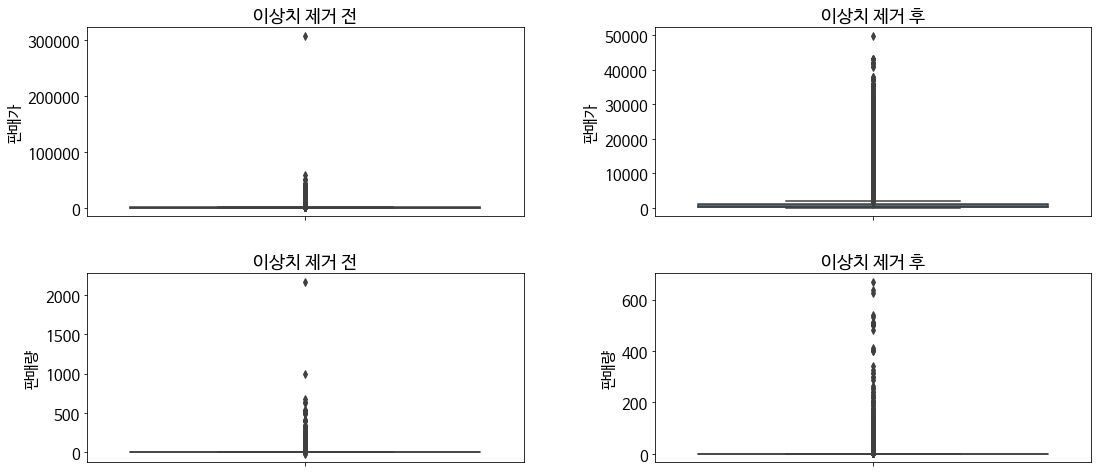

In [6]:
plt.figure(figsize=(18,8)) 
grid = gridspec.GridSpec(2,2)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

ax=plt.subplot(grid[0])
sns.boxplot(y='판매가',data=sales_train,ax=ax)
ax.set_title('이상치 제거 전')

ax=plt.subplot(grid[2])
sns.boxplot(y='판매량',data=sales_train,ax=ax)
ax.set_title('이상치 제거 전')

ax=plt.subplot(grid[1])
sns.boxplot(y='판매가',data=sales_train_outlier,ax=ax)
ax.set_title('이상치 제거 후')

ax=plt.subplot(grid[3])
sns.boxplot(y='판매량',data=sales_train_outlier,ax=ax)
ax.set_title('이상치 제거 후')

plt.show()

이상치때문에 boxplot이 찌그러진줄 알았는데 제거해도 여전히 찌그러져있다.

상점명에 유사해보이는 값이 몇몇 존재한다. tfidf cosine_similarity를 통해서 관계를 알아보자

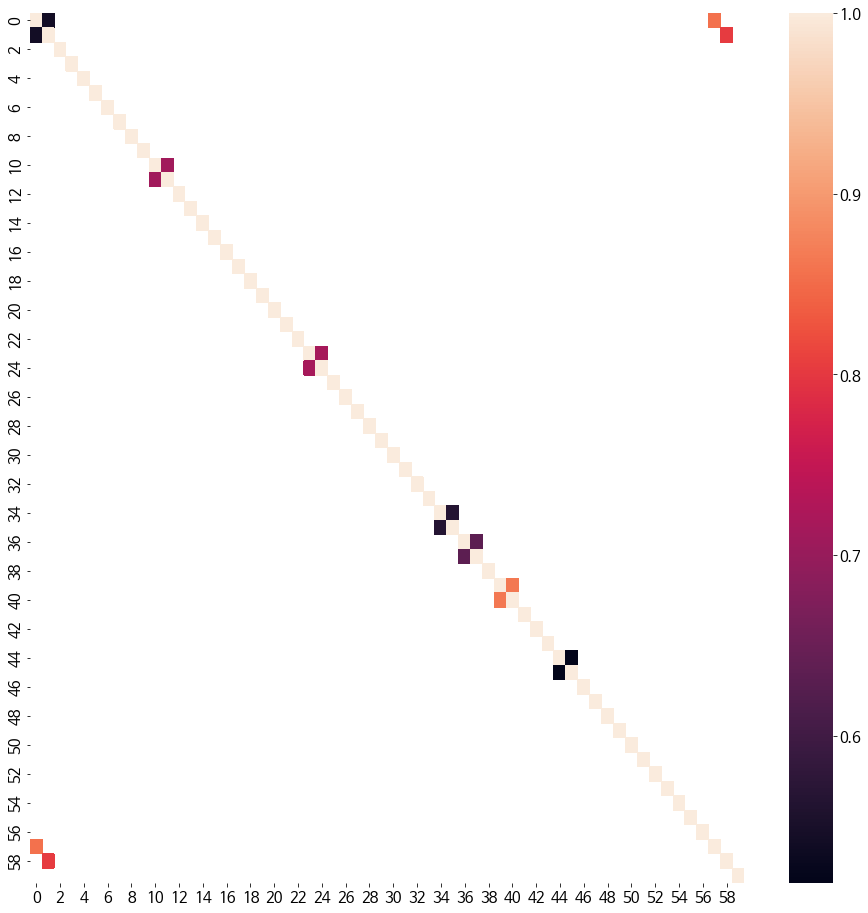

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer().fit_transform(shops['상점명'].to_list()).toarray()

from sklearn.metrics.pairwise import cosine_similarity

tf = pd.DataFrame(tf)

df = pd.DataFrame(cosine_similarity(tf,tf))

#유사도 index 순위
import re
[re.sub('\s+',' ',i).split() for i in str(df[df<(1-1e-6)].idxmax()).split('\n')]

plt.figure(figsize=(16,16)) 
sns.heatmap(df[df>0.5])

In [8]:
#유사도 index 순위
import re
[re.sub('\s+',' ',i).split() for i in str(df[df<(1-1e-6)].idxmax()).split('\n')]

[['0', '57'],
 ['1', '58'],
 ['2', '41'],
 ['3', '25'],
 ['4', '47'],
 ['5', '34'],
 ['6', '7'],
 ['7', '8'],
 ['8', '7'],
 ['9', '0'],
 ['10', '11'],
 ['11', '10'],
 ['12', '22'],
 ['13', '14'],
 ['14', '45'],
 ['15', '29'],
 ['16', '34'],
 ['17', '18'],
 ['18', '17'],
 ['19', '41'],
 ['20', '30'],
 ['21', '4'],
 ['22', '12'],
 ['23', '24'],
 ['24', '23'],
 ['25', '33'],
 ['26', '30'],
 ['27', '28'],
 ['28', '27'],
 ['29', '15'],
 ['30', '31'],
 ['31', '30'],
 ['32', '30'],
 ['33', '25'],
 ['34', '35'],
 ['35', '34'],
 ['36', '37'],
 ['37', '36'],
 ['38', '41'],
 ['39', '40'],
 ['40', '39'],
 ['41', '37'],
 ['42', '43'],
 ['43', '42'],
 ['44', '45'],
 ['45', '44'],
 ['46', '41'],
 ['47', '8'],
 ['48', '34'],
 ['49', '50'],
 ['50', '51'],
 ['51', '50'],
 ['52', '53'],
 ['53', '52'],
 ['54', '41'],
 ['55', '0'],
 ['56', '34'],
 ['57', '0'],
 ['58', '1'],
 ['59', '41'],
 ['dtype:', 'int64']]

나름 책에서 제시하지않은 참신한 방법이라고 생각했는데 똑같은 의미를 가진 4쌍중 3쌍은 상위에 있었지만 하나는 중위권이었고 상위3개를 제외한 나머지 상위권은 지역은 다르지만 플랫폼이 같아서 유사도가 높았다.<br>
일일이 직접 탐색하는것 보다는 빠르니 의미가 있었다고 생각한다!

In [9]:
# sales_train 데이터에서 상점ID 수정
sales_train.loc[sales_train['상점ID'] == 0, '상점ID'] = 57
sales_train.loc[sales_train['상점ID'] == 1, '상점ID'] = 58
sales_train.loc[sales_train['상점ID'] == 10, '상점ID'] = 11
sales_train.loc[sales_train['상점ID'] == 39, '상점ID'] = 40

# test 데이터에서 상점ID 수정
test.loc[test['상점ID'] == 0, '상점ID'] = 57
test.loc[test['상점ID'] == 1, '상점ID'] = 58
test.loc[test['상점ID'] == 10, '상점ID'] = 11
test.loc[test['상점ID'] == 39, '상점ID'] = 40

In [10]:
shops['도시'] = shops['상점명'].apply(lambda x: x.split()[0])

In [11]:
shops['도시'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

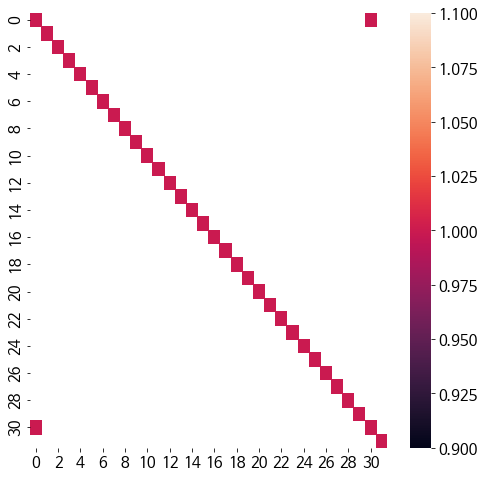

In [12]:
tf = TfidfVectorizer().fit_transform(shops['도시'].unique()).toarray()
tf = pd.DataFrame(tf)
df = pd.DataFrame(cosine_similarity(tf,tf))

plt.figure(figsize=(8,8)) 
sns.heatmap(df[df>0.5])

In [13]:
print(shops['도시'].unique()[30],'\n',shops['도시'].unique()[0])

Якутск 
 !Якутск


도시명에 !는 오타로 보이니 바꿔주자

In [14]:
shops.loc[shops['도시'] =='!Якутск', '도시'] = 'Якутск'

In [15]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코더 생성
label_encoder = LabelEncoder()
# 도시 피처 레이블 인코딩
shops['도시'] = label_encoder.fit_transform(shops['도시'])

In [16]:
try:
    shops.drop('상점명',axis=1,inplace=True)
except:
    print('이미 제거했어용')

shops.head()

,상점ID,도시
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [17]:
try:
    items.drop('상품명',axis=1,inplace=True)
except:
    print('이미 제거했어용')

items

,상품ID,상품분류ID
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40
...,...,...
22165,22165,31
22166,22166,54
22167,22167,49
22168,22168,62


In [18]:
# 상품이 맨 처음 팔린 월을 피처로 만들자
items['첫 판매월'] = sales_train.groupby('상품ID')['월ID'].min()
items.head()

,상품ID,상품분류ID,첫 판매월
0,0,40,20.0
1,1,76,15.0
2,2,40,19.0
3,3,40,18.0
4,4,40,20.0


In [19]:
items.isnull().sum()

상품ID        0
상품분류ID      0
첫 판매월     363
dtype: int64

첫 판매월에 결측값이 있다는것은 판매한적이 없다는 뜻이다.<br>
훈련데이터에서 팔리지 않았다는 것은 훈련데이터의 다음달인 테스트 데이터인 월id==34에 팔렸음을 알 수 있습니다. 결측값을 34로 대체하겠습니다.

In [20]:
items = items.fillna(34)
items.isnull().sum()

상품ID      0
상품분류ID    0
첫 판매월     0
dtype: int64

In [21]:
# 상품분류명의 첫 단어를 대분류로 추출
item_categories['대분류'] = item_categories['상품분류명'].apply(lambda x: x.split()[0])  

In [22]:
item_categories['대분류'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: 대분류, dtype: int64

In [23]:
# 대분류의 고윳값 개수가 5개 미만이면 'etc'로 바꾸기
items_cat = item_categories['대분류'].value_counts()
items_cat = items_cat[items_cat < 5].index
item_categories['대분류'] = item_categories['대분류'].apply(lambda x : 'etc' if x in items_cat else x)
item_categories['대분류'].head()

0           etc
1    Аксессуары
2    Аксессуары
3    Аксессуары
4    Аксессуары
Name: 대분류, dtype: object

In [24]:
item_categories['대분류']

0            etc
1     Аксессуары
2     Аксессуары
3     Аксессуары
4     Аксессуары
         ...    
79           etc
80           etc
81           etc
82           etc
83           etc
Name: 대분류, Length: 84, dtype: object

In [25]:
# 레이블 인코더 생성
label_encoder = LabelEncoder()

# 대분류 피처 레이블 인코딩
item_categories['대분류'] = label_encoder.fit_transform(item_categories['대분류'])

# 상품분류명 피처 제거
item_categories = item_categories.drop('상품분류명', axis=1)

In [26]:
item_categories.head()

,상품분류ID,대분류
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


#데이터 조합 및 파생 피처 생성

In [27]:
from itertools import product

train = []
# 월ID, 상점ID, 상품ID 조합 생성
for i in sales_train['월ID'].unique():
    all_shop = sales_train.loc[sales_train['월ID']==i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID']==i, '상품ID'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [28]:
group = sales_train.groupby(idx_features).agg({'판매량': 'sum',
                                               '판매가': 'mean'})
group = group.reset_index()
group = group.rename(columns={'판매량': '월간 판매량', '판매가': '평균 판매가'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


In [29]:
import gc
del group
gc.collect()

92

In [30]:
# 상품 판매건수 피처 추가
group = sales_train.groupby(idx_features).agg({'판매량': 'count'})
group = group.reset_index()
group = group.rename(columns={'판매량': '판매건수'})

train = train.merge(group, on=idx_features, how='left')

# 가비지 컬렉션
del group, sales_train
gc.collect()

train.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


In [31]:
test['월ID'] = 34

# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


In [32]:
# 나머지 데이터 병합
all_data = all_data.merge(shops, on='상점ID', how='left')
all_data = all_data.merge(items, on='상품ID', how='left')
all_data = all_data.merge(item_categories, on='상품분류ID', how='left')

# 데이터 다운캐스팅
all_data = downcast(all_data)

64.6% 압축됨


기준 피처별 월간 평균 판매량 파생 피처 생성

In [33]:
def add_mean_features(df, mean_features, idx_features):
    # 기준 피처 확인 
    assert (idx_features[0] == '월ID') and \
           len(idx_features) in [2, 3]
    
    # 파생 피처명 설정 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '별 평균 판매량'
    else:
        feature_name = idx_features[1] + ' ' + idx_features[2] + '별 평균 판매량'
    
    # 기준 피처를 토대로 그룹화해 월간 평균 판매량 구하기 
    group = df.groupby(idx_features).agg({'월간 판매량': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'월간 판매량': feature_name})
    
    # df와 group 병합 
    df = df.merge(group, on=idx_features, how='left')
    # 데이터 다운캐스팅 
    df = downcast(df, verbose=False)
    # 새로 만든 feature_name 피처명을 mean_features 리스트에 추가 
    mean_features.append(feature_name)
    
    # 가비지 컬렉션
    del group
    gc.collect()
    
    return df, mean_features

# 그룹화 기준 피처 중 '상품ID'가 포함된 파생 피처명을 담을 리스트
item_mean_features = []

# ['월ID', '상품ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['월ID', '상품ID'])
#print(all_data.head())
# ['월ID', '상품ID', '도시']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['월ID', '상품ID', '도시'])
#print(all_data.head())

In [34]:
item_mean_features

['상품ID별 평균 판매량', '상품ID 도시별 평균 판매량']

In [35]:
# 그룹화 기준 피처 중 '상점ID'가 포함된 파생 피처명을 담을 리스트
shop_mean_features = []

# ['월ID', '상점ID', '상품분류ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['월ID', '상점ID', '상품분류ID'])

In [36]:
shop_mean_features

['상점ID 상품분류ID별 평균 판매량']

In [37]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # 시차 피처 생성에 필요한 DataFrame 부분만 복사 
    df_temp = df[idx_features + [lag_feature]].copy() 

    # 시차 피처 생성 
    for i in range(1, nlags+1):
        # 시차 피처명 
        lag_feature_name = lag_feature +'_시차' + str(i)
        # df_temp 열 이름 설정 
        df_temp.columns = idx_features + [lag_feature_name]
        # df_temp의 date_block_num 피처에 i 더하기 
        df_temp['월ID'] += i
        # idx_feature를 기준으로 df와 df_temp 병합하기 
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # 결측값 0으로 대체 
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # 0 ~ 20 사이로 제한할 시차 피처명을 lag_features_to_clip에 추가 
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # 데이터 다운캐스팅
    df = downcast(df, False)
    # 가비지 컬렉션
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip


In [38]:
lag_features_to_clip = [] # 0 ~ 20 사이로 제한할 시차 피처명을 담을 리스트
idx_features = ['월ID', '상점ID', '상품ID'] # 기준 피처

# idx_features를 기준으로 월간 판매량의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='월간 판매량', 
                                                  nlags=3,
                                                  clip=True) # 값을 0 ~ 20 사이로 제한

In [39]:
all_data.head().T

,0,1,2,3,4
월ID,0.000000,0.0,0.000000,0.000000,0.000000
상점ID,59.000000,59.0,59.000000,59.000000,59.000000
상품ID,22154.000000,2552.0,2554.000000,2555.000000,2564.000000
월간 판매량,1.000000,0.0,0.000000,0.000000,0.000000
평균 판매가,999.000000,0.0,0.000000,0.000000,0.000000
판매건수,1.000000,0.0,0.000000,0.000000,0.000000
도시,30.000000,30.0,30.000000,30.000000,30.000000
상품분류ID,37.000000,58.0,58.000000,56.000000,59.000000
첫 판매월,0.000000,0.0,0.000000,0.000000,0.000000
대분류,5.000000,7.0,7.000000,7.000000,7.000000


In [40]:
lag_features_to_clip

['월간 판매량_시차1', '월간 판매량_시차2', '월간 판매량_시차3']

In [41]:
# idx_features를 기준으로 판매건수 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='판매건수', 
                                                  nlags=3)

# idx_features를 기준으로 평균 판매가 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='평균 판매가', 
                                                  nlags=3)

In [44]:
item_mean_features

['상품ID별 평균 판매량', '상품ID 도시별 평균 판매량']

In [43]:
# idx_features를 기준으로 item_mean_features 요소별 시차 피처 생성
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# item_mean_features 피처 제거
all_data = all_data.drop(item_mean_features, axis=1)

In [45]:
shop_mean_features

['상점ID 상품분류ID별 평균 판매량']

In [46]:
# ['월ID', '상점ID', '상품분류ID']를 기준으로 shop_mean_features 요소별 시차 피처 생성
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['월ID', '상점ID', '상품분류ID'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# shop_mean_features 피처 제거
all_data = all_data.drop(shop_mean_features, axis=1)

In [47]:
# 월ID 3미만인 데이터 제거
all_data = all_data.drop(all_data[all_data['월ID'] < 3].index)

In [49]:
all_data['월간 판매량 시차평균'] = all_data[['월간 판매량_시차1',
                                          '월간 판매량_시차2', 
                                          '월간 판매량_시차3']].mean(axis=1)
# 0 ~ 20 사이로 값 제한
all_data[lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']] = all_data[lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']].clip(0, 20)
#시차 변화량
all_data['시차변화량1'] = all_data['월간 판매량_시차1']/all_data['월간 판매량_시차2']
all_data['시차변화량1'] = all_data['시차변화량1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['시차변화량2'] = all_data['월간 판매량_시차2']/all_data['월간 판매량_시차3']
all_data['시차변화량2'] = all_data['시차변화량2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)
#신상 여부
all_data['신상여부'] = all_data['첫 판매월'] == all_data['월ID']

In [50]:
#첫 판매 후 경과 기간
all_data['첫 판매 후 기간'] = all_data['월ID'] - all_data['첫 판매월']
#월(month)
all_data['월'] = all_data['월ID'] % 12
#필요 없는 피처 제거
# 첫 판매월, 평균 판매가, 판매건수 피처 제거
all_data = all_data.drop(['첫 판매월', '평균 판매가', '판매건수'], axis=1)
all_data = downcast(all_data, False) # 데이터 다운캐스팅

In [51]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9933528 entries, 1122795 to 11056322
Data columns (total 31 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   월ID                      int8   
 1   상점ID                     int8   
 2   상품ID                     int16  
 3   월간 판매량                   int8   
 4   도시                       int8   
 5   상품분류ID                   int8   
 6   대분류                      int8   
 7   월간 판매량_시차1               int8   
 8   월간 판매량_시차2               int8   
 9   월간 판매량_시차3               int8   
 10  판매건수_시차1                 int8   
 11  판매건수_시차2                 int8   
 12  판매건수_시차3                 int8   
 13  평균 판매가_시차1               float32
 14  평균 판매가_시차2               float32
 15  평균 판매가_시차3               float32
 16  상품ID별 평균 판매량_시차1         float32
 17  상품ID별 평균 판매량_시차2         float32
 18  상품ID별 평균 판매량_시차3         float32
 19  상품ID 도시별 평균 판매량_시차1      float32
 20  상품ID 도시별 평균 판매량_시차2      float32
 21  상

#훈련 데이터 생성

In [52]:
# 훈련 데이터 (피처)
X_train = all_data[all_data['월ID'] < 33]
X_train = X_train.drop(['월간 판매량'], axis=1)
# 검증 데이터 (피처)
X_valid = all_data[all_data['월ID'] == 33]
X_valid = X_valid.drop(['월간 판매량'], axis=1)
# 테스트 데이터 (피처)
X_test = all_data[all_data['월ID'] == 34]
X_test = X_test.drop(['월간 판매량'], axis=1)

# 훈련 데이터 (타깃값)
y_train = all_data[all_data['월ID'] < 33]['월간 판매량']
# 검증 데이터 (타깃값)
y_valid = all_data[all_data['월ID'] == 33]['월간 판매량']

# 가비지 컬렉션
del all_data
gc.collect();

#모델 훈련 및 성능 검증¶

In [53]:
import lightgbm as lgb

# LightGBM 하이퍼파라미터
params = {'metric': 'rmse', 
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise': True,
          'random_state': 10}

cat_features = ['상점ID', '도시', '상품분류ID', '대분류', '월']

# LightGBM 훈련 및 검증 데이터셋
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# LightGBM 모델 훈련
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)      

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['대분류', '도시', '상점ID', '상품분류ID', '월']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 150 rounds.
[100]	training's rmse: 1.01036	valid_1's rmse: 0.986667
[200]	training's rmse: 0.909855	valid_1's rmse: 0.924058
[300]	training's rmse: 0.85919	valid_1's rmse: 0.897753
[400]	training's rmse: 0.831132	valid_1's rmse: 0.886714
[500]	training's rmse: 0.812438	valid_1's rmse: 0.883359
[600]	training's rmse: 0.79912	valid_1's rmse: 0.881688
[700]	training's rmse: 0.789277	valid_1's rmse: 0.880666
[800]	training's rmse: 0.780876	valid_1's rmse: 0.880649
[900]	training's rmse: 0.774199	valid_1's rmse: 0.880738
Early stopping, best iteration is:
[826]	training's rmse: 0.779199	valid_1's rmse: 0.88054


In [54]:
# 예측
preds = lgb_model.predict(X_test).clip(0, 20)

# 제출 파일 생성
submission['item_cnt_month'] = preds
submission.to_csv('submission.csv', index=False)

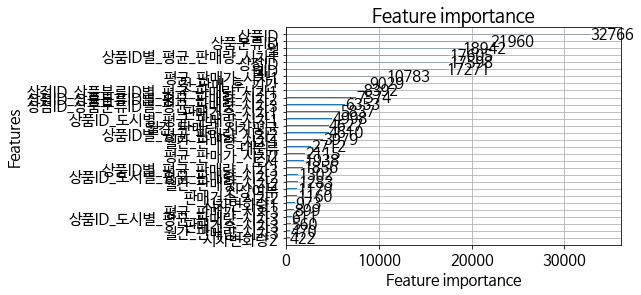

In [58]:
from lightgbm import plot_importance
plot_importance(lgb_model)